## Trabalho Prático de Introdução ao Processamento Digital de Imagens

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

### RGB-HSB-RGB conversion

#### RGB -> HSB

In [82]:
def rgb_to_hsb(pixel):
    R, G, B = pixel
    pixel  =  R / 255, G / 255, B / 255
    R, G, B = pixel

    MAX = max(pixel)
    MIN = min(pixel)  
    
    # Hue value
    H = None
    S = None
    if(MAX == MIN):
        H = 0
    elif((MAX == R)):
        if(G >= B):
            H = 60 * ((G - B)/(MAX - MIN))
        else:
            H = (60 * ((G - B)/(MAX - MIN))) + 360
    
    elif(MAX == G):
        H = (60 * ((B - R)/(MAX - MIN))) + 120
    
    elif(MAX == B):
        H = (60 * ((R - G)/(MAX - MIN))) + 240

    # Saturation

    if(MAX == 0):
        S = 0
    else:
        S = 1 - (MIN/ MAX)

    
    B = MAX

    return round(H), round(S, 2), round(B, 2)

In [83]:
rgb_to_hsb((100, 100, 0))

(60, 1.0, 0.39)

#### HSB -> RGB

In [91]:
def hsb_to_rgb(pixel):
    H, S, B = pixel
    
    Hi = (H / 60) % 6
    f  = (H / 60) - Hi
    p  = B * (1 - S)
    q  = B * (1 - f * S)
    t  = B * (1- (1- f) * S)

    if(Hi == 0):
        R = B 
        G = t 
        B = p 
        return (int(255 * R), int(255 * G), int(255 *B))
    if(Hi == 1):
        R = q
        G = B
        B = p
        return (int(255 * R), int(255 * G), int(255 *B))
    if(Hi == 2):
        R = p
        G = B
        B = t 
        return (int(255 * R), int(255 * G), int(255 *B))
    if(Hi == 3):
        R = p
        G = q
        B = B
        return (int(255 * R), int(255 * G), int(255 *B))
    if(Hi == 4):
        R = t
        G = p
        B = B
        return (int(255 * R), int(255 * G), int(255 *B))
    
    if(Hi == 5):
        R = B 
        G = p
        B = q
        return (int(255 * R), int(255 * G), int(255 *B))

In [92]:
hsb_to_rgb((60, 1.0, 0.39))

(99, 99, 0)

### Correlação

In [2]:
def load_filter(filter_path):
    with open(filter_path, 'r') as file:
        line = file.readline()
        values = [float(x) for x in line.split()]
    
    m =  int(values[0])
    n = int(values[1])
    stride = int(values[2])

    filter = []
    for i in range(0, m):
        row = []
        for j in range(0, n):    
            row.append(values[3:][i*n + j])
        filter.append(row)
    
    return stride, np.array(filter)

def apply_correlation(matrix, filter, stride=1):
    if(stride > 1):
        return convolve2d(matrix, filter, mode='valid')[::stride, ::stride].astype(int)
    else:
        return convolve2d(matrix, filter, mode='valid').astype(int)
    
def apply_transform_box(image_channels, stride, filter):
    # Record the start time
    start_time = time.time()

    R, G, B = image_channels
    
    R_box = apply_correlation(R, filter, stride)
    G_box = apply_correlation(G, filter, stride)
    B_box = apply_correlation(B, filter, stride)

    img_merged_box = cv2.merge((R_box, G_box, B_box))

    # Record the end time
    end_time = time.time()
    
    return img_merged_box, end_time - start_time

def histogram_expansion(matrix):
    r_max = matrix.max()
    r_min = matrix.min()
    l = 255

    expansion = lambda r : round((r - r_min) * (l - 1) / (r_max - r_min))

    return np.vectorize(expansion)(matrix)


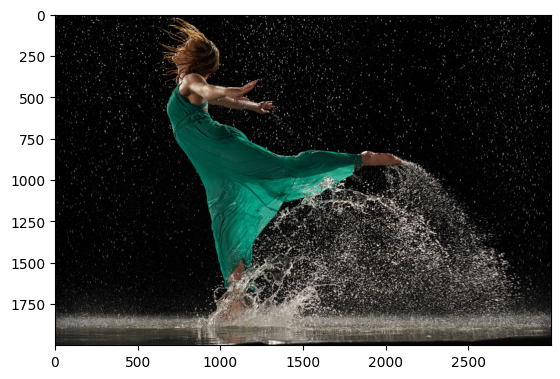

In [3]:
img = cv2.cvtColor(cv2.imread("DancingInWater.jpg"), cv2.COLOR_BGR2RGB)
# show image
plt.imshow(img)

In [4]:
img.shape

(2000, 3000, 3)

#### Filtro box 15x15

Execution time: 5058.864ms


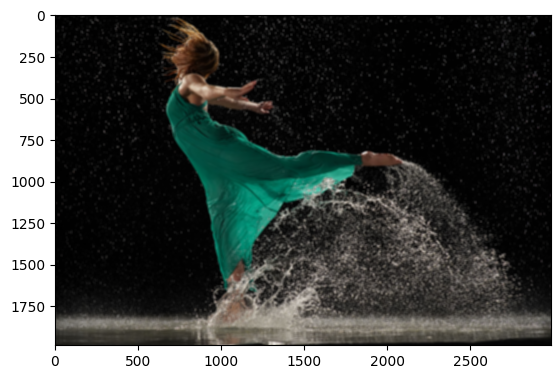

In [5]:
stride_15x15, filter_box_15x15 = load_filter("filtro_box_15x15.txt")
img_merged_box_15x15, exec_time_box_15x15 = apply_transform_box(cv2.split(img), stride_15x15, filter_box_15x15)
plt.imshow(img_merged_box_15x15)
print(f"Execution time: {round(exec_time_box_15x15*1000, 3)}ms")

In [6]:
img_merged_box_15x15.shape

(1986, 2986, 3)

#### Box filter 1x15 followed by box filter 15x1

Execution time: 1373.049ms


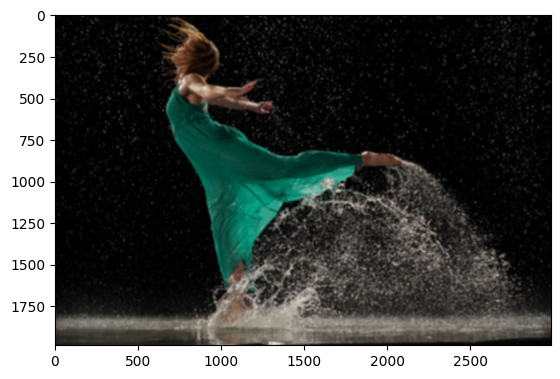

In [7]:
stride_1x15, filter_box_1x15 = load_filter("filtro_box_1x15.txt")
img_merged_box_1x15, exec_time_box_1x15 = apply_transform_box(cv2.split(img), stride_1x15, filter_box_1x15)

stride_15x1, filter_box_15x1 = load_filter("filtro_box_15x1.txt")
img_merged_box_15x1, exec_time_box_15x1 = apply_transform_box(cv2.split(img_merged_box_1x15), stride_15x1, filter_box_15x1)

print(f"Execution time: {round((exec_time_box_1x15 + exec_time_box_15x1)*1000, 3)}ms")
plt.imshow(img_merged_box_15x1)

In [8]:
img_merged_box_15x1.shape

(1986, 2986, 3)

### Filtro de Sobel

In [10]:
img = cv2.cvtColor(cv2.imread("Shapes.png"), cv2.COLOR_BGR2RGB)

libpng warning: iCCP: known incorrect sRGB profile


In [12]:
R, G, B = cv2.split(img)

stride_horizontal, filtro_sobel_horizontal = load_filter("filtro_sobel_horizontal.txt")

R_sobel_horizontal = np.abs(apply_correlation(R, filtro_sobel_horizontal, stride_horizontal))
G_sobel_horizontal = np.abs(apply_correlation(G, filtro_sobel_horizontal, stride_horizontal))
B_sobel_horizontal = np.abs(apply_correlation(B, filtro_sobel_horizontal, stride_horizontal))

stride_vertical, filtro_sobel_vertical = load_filter("filtro_sobel_vertical.txt")

R_sobel_vertical = np.abs(apply_correlation(R, filtro_sobel_vertical, stride_vertical))
G_sobel_vertical = np.abs(apply_correlation(G, filtro_sobel_vertical, stride_vertical))
B_sobel_vertical = np.abs(apply_correlation(B, filtro_sobel_vertical, stride_vertical))


In [13]:
R_sobel = histogram_expansion(R_sobel_horizontal + R_sobel_vertical)
G_sobel = histogram_expansion(G_sobel_horizontal + G_sobel_vertical)
B_sobel = histogram_expansion(B_sobel_horizontal + B_sobel_vertical)



#### Sobel applied over R channel

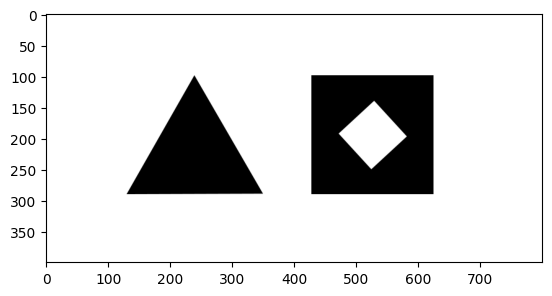

In [14]:
plt.imshow(img)

In [15]:
R_sobel

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

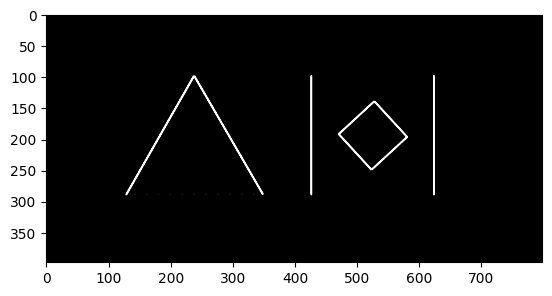

In [22]:
plt.imshow(R_sobel_vertical, cmap='gray', vmin=0, vmax=255)

In [17]:
G_sobel

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### Sobel applied over G channel

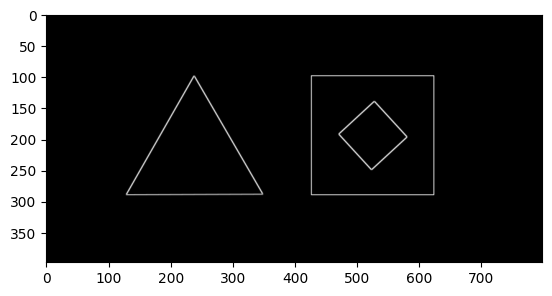

In [18]:
plt.imshow(G_sobel, cmap='gray', vmin=0, vmax=255)

In [19]:
B_sobel

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### Sobel applied over B channel

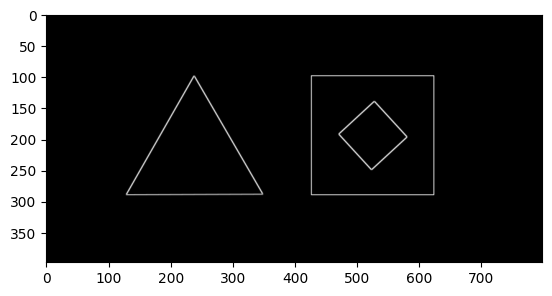

In [20]:
plt.imshow(B_sobel, cmap='gray', vmin=0, vmax=255)